In [1]:
import gym
import gym_minigrid
import matplotlib.pyplot as plt
import torch.nn.functional as F
plt.style.use('ggplot')

%load_ext autoreload
%autoreload 2

In [2]:
from gym.wrappers import Monitor
from gym_minigrid.wrappers import FullyObsWrapper, RGBImgObsWrapper


env = gym.make("MiniGrid-Dynamic-Obstacles-8x8-v0")

env = FullyObsWrapper(env)
env = RGBImgObsWrapper(env)
env = Monitor(env, '../experiments/artifacts/video/', force=True)

In [3]:
import sys

sys.path.append('..')

from rllr.utils.plotting.video import show_video

In [4]:
done = False

env = gym.make("MiniGrid-Dynamic-Obstacles-8x8-v0")
env = FullyObsWrapper(env)
env = RGBImgObsWrapper(env)
env = Monitor(env, '../experiments/artifacts/video/', force=True)
env.reset()

while not done:
    a = env.action_space.sample()
    s, r, done, info = env.step(a)

show_video()

In [5]:
import torch
from skimage.transform import resize
import numpy as np

device = "cpu"



def rollout(env):
    
    states, next_states, actions = [],  [], []
    done = False
    
    state = env.reset()
    i = 0
    
    while not done:
        action = env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        states.append(state['image']/256) 
        next_states.append(next_state['image']/256)
        actions.append(action)
        state = next_state
        i+=1
    
    states = torch.from_numpy(np.array(states)).to(device, dtype=torch.float32)
    next_states = torch.from_numpy(np.array(next_states)).to(device, dtype=torch.float32)
    actions = torch.from_numpy(np.array(actions)).to(device)
    return states, next_states, F.one_hot(actions, num_classes=env.action_space.n)

In [6]:
states, next_states, actions = rollout(env)

In [7]:
states.size()

torch.Size([11, 64, 64, 3])

In [8]:
actions.size()

torch.Size([11, 3])

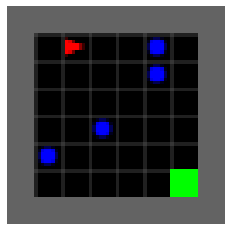

In [9]:
plt.axis('off')
plt.imshow(states[1])
plt.show()

In [10]:
import torch
from torch import nn
from functools import reduce

class Permute(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.dims = args

    def forward(self, x):
        return x.permute(self.dims)

class ForwardVAEModel(nn.Module):

    def __init__(self, input_size, n_channels, kernel_sizes, strides, hidden_sizes, action_size):
        super(ForwardVAEModel, self).__init__()

        # Encoder convolutional layers
        conv_layers_enc = [Permute(0, 3, 1, 2)]
        self.input_size = input_size
        cnn_output_size = self.input_size[:-1]
        cur_channels = self.input_size[-1]
        conv_params = zip(n_channels, kernel_sizes, strides)
        for n_channel, kernel_size, stride in conv_params:
            conv_layers_enc.append(nn.Conv2d(cur_channels, n_channel, kernel_size, stride))
            conv_layers_enc.append(nn.ReLU(inplace=True))
            cnn_output_size_x = (cnn_output_size[0] - kernel_size + stride) // stride
            cnn_output_size_y = (cnn_output_size[1] - kernel_size + stride) // stride
            cnn_output_size = [cnn_output_size_x, cnn_output_size_y]
            cur_channels = n_channel
        self.enc_conv_net = nn.Sequential(*conv_layers_enc)
        self.cnn_output_sizes = [cur_channels] + cnn_output_size

        # Encoder fully connected layers
        fc_layers_enc = []
        output_size = reduce(lambda x, y: x * y, self.cnn_output_sizes)
        for hidden_size in hidden_sizes:
            fc_layers_enc.append(nn.Linear(output_size, hidden_size))
            fc_layers_enc.append(nn.ReLU(inplace=True))
            output_size = hidden_size

        fc_layers = fc_layers_enc[:-1]
        self.enc_mu = nn.Sequential(*fc_layers)
        self.enc_var = nn.Sequential(*fc_layers)

        # Decoder fully connected layers
        fc_layes_dec = []
        input_size = hidden_sizes[-1] + action_size
        output_size = reduce(lambda x, y: x * y, self.cnn_output_sizes)
        for hidden_size in hidden_sizes[:-1][::-1]:
            fc_layes_dec.append(nn.Linear(input_size, hidden_size))
            fc_layes_dec.append(nn.ReLU(inplace=True))
            input_size = hidden_size
        fc_layes_dec.append(nn.Linear(input_size, output_size))
        fc_layes_dec.append(nn.ReLU(inplace=True))
        self.dec_fc = nn.Sequential(*fc_layes_dec)
        conv_layers_dec = []

        # Decoder deconvolution layers
        n_channels = [3] + n_channels[:-1]
        deconv_params = zip(n_channels[::-1], kernel_sizes[::-1], strides[::-1])
        for n_channel, kernel_size, stride in deconv_params:
            conv_layers_dec.append(nn.ConvTranspose2d(cur_channels, n_channel, kernel_size, stride))
            conv_layers_dec.append(nn.ReLU(inplace=True))
            cur_channels = n_channel
        conv_layers_dec = conv_layers_dec[:-1]
        conv_layers_dec.append(Permute(0, 2, 3, 1))
        self.dec_conv_net = nn.Sequential(*conv_layers_dec)

    def encoder(self, x):
        x = self.enc_conv_net(x)
        x = x.view(-1, reduce(lambda x, y: x * y, self.cnn_output_sizes))
        mu = self.enc_mu(x)
        log_var = self.enc_var(x)
        return mu, log_var

    def _reparameterize(self, mu, log_var):
        std = torch.exp(log_var / 2)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decoder(self, z, actions):
        z = torch.cat([z, actions], dim=1)
        x = self.dec_fc(z)
        x = x.view(-1, *self.cnn_output_sizes)
        x = self.dec_conv_net(x)
        return torch.sigmoid(x)

    def forward(self, states, actions):
        mu, log_var = self.encoder(states)
        z = self._reparameterize(mu, log_var)
        out = self.decoder(z, actions)
        return out, mu, log_var

In [11]:
net = ForwardVAEModel(tuple(states.size()[1:]), n_channels=[16, 32], kernel_sizes=[5, 5], strides=[1, 1], hidden_sizes=[32, 32, 32], action_size=env.action_space.n).to(device)
net

ForwardVAEModel(
  (enc_conv_net): Sequential(
    (0): Permute()
    (1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU(inplace=True)
  )
  (enc_mu): Sequential(
    (0): Linear(in_features=100352, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=32, out_features=32, bias=True)
  )
  (enc_var): Sequential(
    (0): Linear(in_features=100352, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=32, out_features=32, bias=True)
  )
  (dec_fc): Sequential(
    (0): Linear(in_features=35, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_f

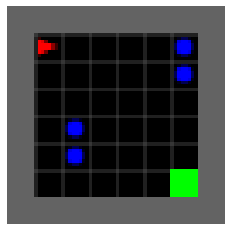

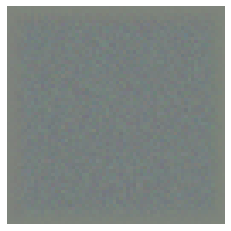

In [12]:
image_size = tuple(states.size()[1:])
dec = net(states, actions)[0].detach()

plt.axis('off')
plt.imshow(states[0])
plt.show()

plt.axis('off')
plt.imshow(dec[0])
plt.show()

In [14]:
from torch.nn import functional as F

num_epochs = 5000
learning_rate = 1e-3

"""
Initialize the network and the Adam optimizer
"""
image_size = tuple(states.size()[1:])
net = ForwardVAEModel(tuple(states.size()[1:]), n_channels=[16, 32], kernel_sizes=[5, 5], 
                      strides=[1, 1], hidden_sizes=[32], action_size=env.action_space.n).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)


"""
Training the network for a given number of epochs
The loss after every epoch is printed
"""

done = True

for epoch in range(num_epochs):
    states, next_states, actions = rollout(env)
    states = states.to(device)
    next_states = next_states.to(device)
    actions = actions.to(device)
    
    # Feeding a batch of images into the network to obtain the output image, mu, and logVar
    out, mu, logVar = net(states, actions)

    # The loss is the BCE loss combined with the KL divergence to ensure the distribution is learnt
    kl_divergence = 0.5 * torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
    loss = F.binary_cross_entropy(out, next_states, size_average=False) + kl_divergence

    # Backpropagation based on the loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch%100==0:
        print('Epoch {}: Loss {}'.format(epoch, loss))
        

/opt/anaconda3/envs/rllr/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 0: Loss 62903.12890625


/opt/anaconda3/envs/rllr/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/opt/anaconda3/envs/rllr/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/opt/anaconda3/envs/rllr/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 100: Loss 65610.3359375


/opt/anaconda3/envs/rllr/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 200: Loss 32333.63671875


/opt/anaconda3/envs/rllr/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 300: Loss 4636.0654296875


/opt/anaconda3/envs/rllr/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 400: Loss 31996.33203125
Epoch 500: Loss 50285.80859375


/opt/anaconda3/envs/rllr/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 600: Loss 27307.37890625
Epoch 700: Loss 13681.7275390625


/opt/anaconda3/envs/rllr/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 800: Loss 27378.212890625
Epoch 900: Loss 27162.44140625


/opt/anaconda3/envs/rllr/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 1000: Loss 13610.7998046875
Epoch 1100: Loss 63882.99609375
Epoch 1200: Loss 31901.26171875
Epoch 1300: Loss 18229.71875
Epoch 1400: Loss 9039.3134765625
Epoch 1500: Loss 50094.453125
Epoch 1600: Loss 13574.2734375
Epoch 1700: Loss 68666.421875
Epoch 1800: Loss 40800.33984375
Epoch 1900: Loss 36425.0546875


/opt/anaconda3/envs/rllr/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 2000: Loss 27058.181640625
Epoch 2100: Loss 13580.1533203125
Epoch 2200: Loss 22584.29296875
Epoch 2300: Loss 9046.0732421875
Epoch 2400: Loss 18312.76953125
Epoch 2500: Loss 31895.0078125
Epoch 2600: Loss 26938.841796875
Epoch 2700: Loss 22618.568359375
Epoch 2800: Loss 8979.4462890625
Epoch 2900: Loss 72788.578125


/opt/anaconda3/envs/rllr/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 3000: Loss 9021.919921875
Epoch 3100: Loss 36146.46875
Epoch 3200: Loss 18235.1328125
Epoch 3300: Loss 27030.3671875
Epoch 3400: Loss 172026.6875
Epoch 3500: Loss 49671.1171875
Epoch 3600: Loss 18082.91796875
Epoch 3700: Loss 13571.4189453125
Epoch 3800: Loss 22498.392578125
Epoch 3900: Loss 18036.82421875


/opt/anaconda3/envs/rllr/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 4000: Loss 13502.4130859375
Epoch 4100: Loss 54372.79296875
Epoch 4200: Loss 9076.3017578125
Epoch 4300: Loss 13490.1591796875
Epoch 4400: Loss 17963.23046875
Epoch 4500: Loss 40361.66796875
Epoch 4600: Loss 26873.865234375
Epoch 4700: Loss 58802.64453125
Epoch 4800: Loss 8953.341796875
Epoch 4900: Loss 17999.662109375


/opt/anaconda3/envs/rllr/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [15]:
env = gym.make("MiniGrid-Dynamic-Obstacles-8x8-v0")
env = FullyObsWrapper(env)
env = RGBImgObsWrapper(env)
env = Monitor(env, '../experiments/artifacts/video/', force=True)
env.reset()

action = 2
state1, reward, done, info = env.step(action)

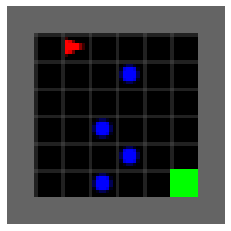

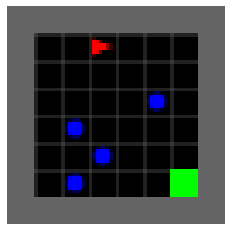

Distance 4.538557529449463


In [16]:
state2, reward, done, info = env.step(2)

plt.axis(False)
plt.imshow(state1['image'])
plt.show()
plt.axis(False)
plt.imshow(state2['image'])
plt.show()

embed1, _ = net.encoder(torch.from_numpy(np.array([state1['image']/256])).to(device, dtype=torch.float32))
embed2, _ = net.encoder(torch.from_numpy(np.array([state2['image']/256])).to(device, dtype=torch.float32))
print('Distance', torch.dist(embed1, embed2, 2).detach().item())

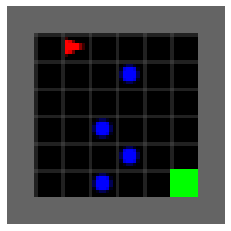

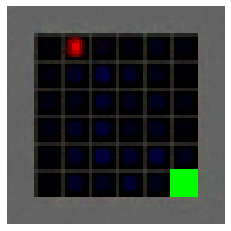

In [51]:
states = torch.from_numpy(np.array([state1['image']/256])).to(device, dtype=torch.float32)
actions = torch.from_numpy(np.array([1])).to(device)
actions = F.one_hot(actions, num_classes=env.action_space.n)

dec = net(states, actions)[0].detach()


plt.axis('off')
plt.imshow(state1['image'])
plt.show()

plt.axis('off')
plt.imshow(dec[0])
plt.show()